In [1]:
# Import necessary packages
import os
import sys
import random
import warnings
import math
import re
from tqdm import tqdm
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set parameters
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = './new_data/14'
TEST_PATH = './new_data/14'


/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
num_test_items = int(0.1 * len(train_ids))

# Slice the train_ids list to get the test IDs
test_ids = train_ids[-num_test_items:]


In [3]:

sequences = {}
masks = {}
time_steps_list = []

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_2 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    
    # Extract time step 
    match = re.search(r'_i(\d+)_', id_)
    if match:
        time_step = int(match.group(1))
    else:
        raise ValueError(f"Time step not found in the filename: {id_}")
    time_steps_list.append(time_step)
    
    img_path = os.path.join(path, 'images', id_ + '_mSLIM' + '.png')
    img = imread(img_path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1).astype(np.float64)
    X_train[n] = img.astype(np.float64)
    
    # Load masks
    for mask_file in next(os.walk(os.path.join(path, 'masks/')))[2]:
        mask = imread(os.path.join(path, 'masks', mask_file))
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        if mask_file.endswith('Prot.png'):
            Y_train_2[n] = np.where(mask[:, :, np.newaxis] > 0, 2, 0)
        else:
            Y_train_1[n] = np.where(mask[:, :, np.newaxis] > 0, 1, 0)

    Y_train[n] = np.maximum(Y_train_1[n], Y_train_2[n])
    
    if time_step not in sequences:
        sequences[time_step] = []
        masks[time_step] = []
    sequences[time_step].append(img)
    masks[time_step].append(Y_train[n])

# Sort sequences by time steps
time_steps = sorted(sequences.keys())
X_sequences = [np.stack(sequences[t]) for t in time_steps]
Y_sequences = [np.stack(masks[t]) for t in time_steps]

X_sequences = np.array(X_sequences)  
Y_sequences = np.array(Y_sequences)


Getting and resizing train images and masks ... 


100%|██████████| 270/270 [02:44<00:00,  1.64it/s]


In [ ]:

print('Data loaded and resized.')
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0] * test_ratio)

X_test = x_val[split_test:]
Y_test = y_val[split_test:]
x_val = x_val[:split_test]
y_val = y_val[:split_test]

x_train_tensor = torch.from_numpy(x).float()
y_train_tensor = torch.from_numpy(y).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

x_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(Y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


Data loaded and resized.


In [5]:

def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


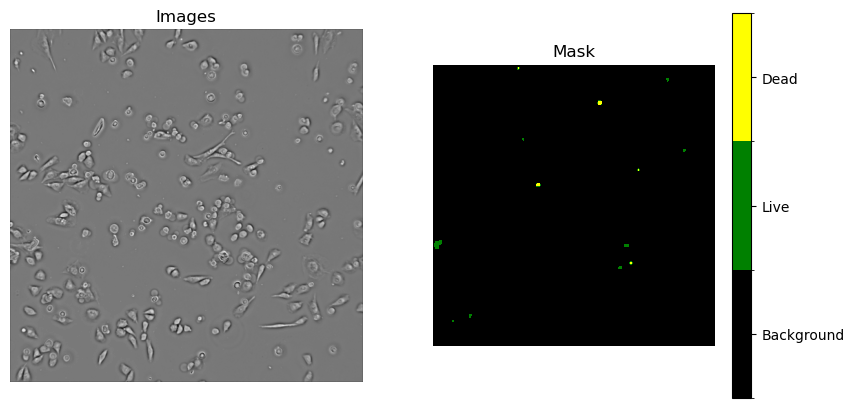

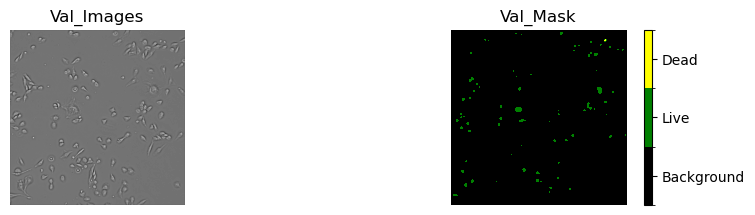

In [6]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[5,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[5],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[5,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[5],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [7]:

# Define IoU metric
import torch

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))



In [8]:


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, name="null"):
        self.patience = patience
        self.verbose = verbose
        self.name = name
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), f'checkpoint_{self.name}.pth')


In [9]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint_unet.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True, name="unet")
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
def calculate_metrics(y_true, y_pred):
    # Flatten the predictions and true labels to compute pixel-wise values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[1, 2])
    precision = precision_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)
    recall = recall_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)
    f1 = f1_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)

    return cm, precision, recall, f1

In [19]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
train_predictions = []
train_labels = []
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    train_predictions.clear()
    train_labels.clear()
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()
        preds = torch.argmax(outputs, dim=1)
        train_predictions.append(preds.cpu().numpy())
        train_labels.append(labels.cpu().numpy())
        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint_unet.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    y_true = np.concatenate(train_labels, axis=0)
    y_pred = np.concatenate(train_predictions, axis=0)
    cm, precision, recall, f1 = calculate_metrics(y_true, y_pred)

    # Print metrics
    print("\nTraining Metrics for Epoch [{}]:".format(epoch + 1))
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision (Live, Dead): {precision * 100}%")
    print(f"Recall (Live, Dead): {recall * 100}%")
    print(f"F1 Score (Live, Dead): {f1 * 100}%\n")
    
    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
    break
    
torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')


 24%|██▎       | 51/216 [00:37<02:01,  1.36it/s]

Epoch 1: Batch[50/216] Loss: 0.0005881405933905626 IoU: 0.9935430419445038


 46%|████▋     | 100/216 [01:13<01:25,  1.36it/s]

Epoch 1: Batch[100/216] Loss: 0.0005678464429365703 IoU: 0.9875772362947464
Saving model...


 70%|██████▉   | 151/216 [01:51<00:47,  1.37it/s]

Epoch 1: Batch[150/216] Loss: 0.000555026289196879 IoU: 0.9857848076025645


 93%|█████████▎| 200/216 [02:27<00:11,  1.37it/s]

Epoch 1: Batch[200/216] Loss: 0.0005293570342564635 IoU: 0.9847601184248924
Saving model...


100%|██████████| 216/216 [02:39<00:00,  1.36it/s]


Epoch [1/100] Loss: 0.000518483836795322 IoU: 0.9801749482198998

Training Metrics for Epoch [1]:
Confusion Matrix:
[[284971     22]
 [    31  47309]]
Precision (Live, Dead): [98.34385892 98.57479216]%
Recall (Live, Dead): [98.4804816  98.75587099]%
F1 Score (Live, Dead): [98.41212284 98.66524849]%

EarlyStopping counter: 7 out of 5
Early stopping triggered
Best loss is 0.000518483836795322, best iou is 0.9801749482198998


In [11]:
model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 27/27 [00:12<00:00,  2.08it/s]

Validation Loss: 0.013545933926555639, Validation IoU: 0.8385777495525502


In [12]:

model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


In [13]:

def transform(preds):
    
    preds_val_transformed = []
    
    for pre in preds:
        preds_argmax = torch.argmax(pre, dim=1)
        #print(preds_argmax.shape)
        preds_val_transformed.append(preds_argmax)
        
    preds = torch.cat(preds_val_transformed, dim=0)
    
    return preds


In [14]:

preds_val_t = transform(preds_val)
preds_test_t = transform(preds_test)
print(preds_val_t.shape)


torch.Size([27, 512, 512])


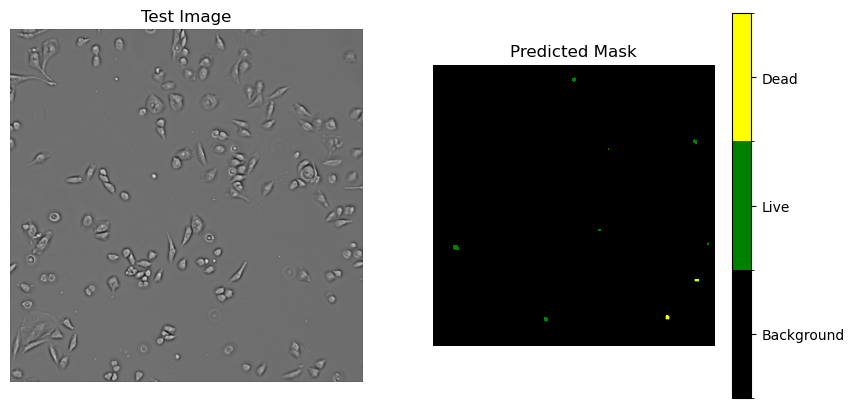

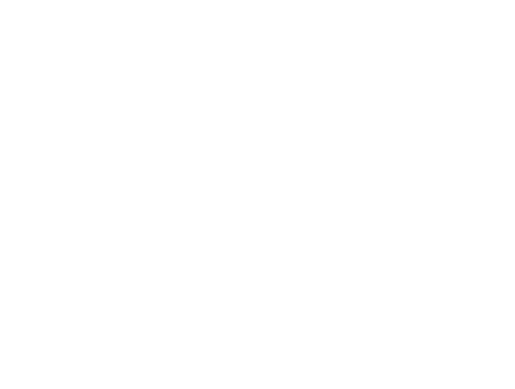

In [15]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0]
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

#predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
# print(preds_test_t.shape)

# if predicted_mask.ndim == 1:
#     predicted_mask = predicted_mask.reshape(128, 128)
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()

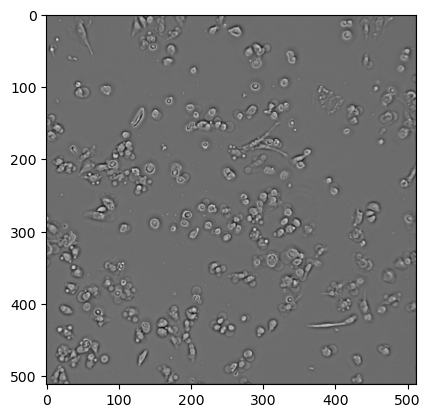

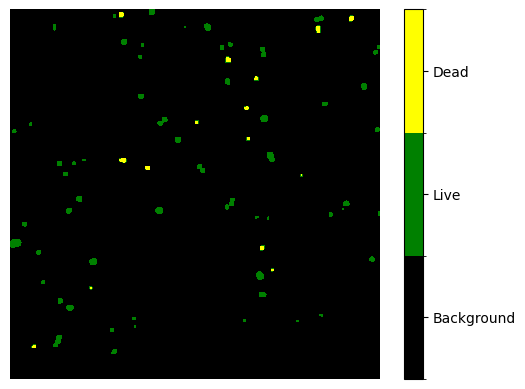

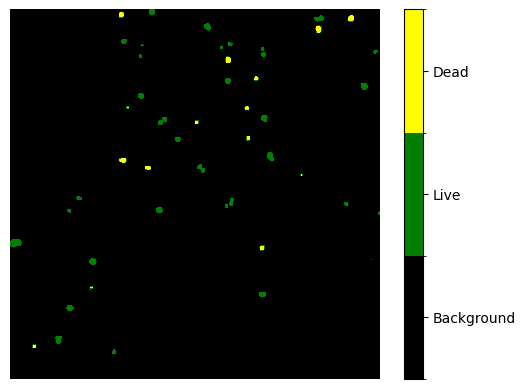

In [16]:


import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
#predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

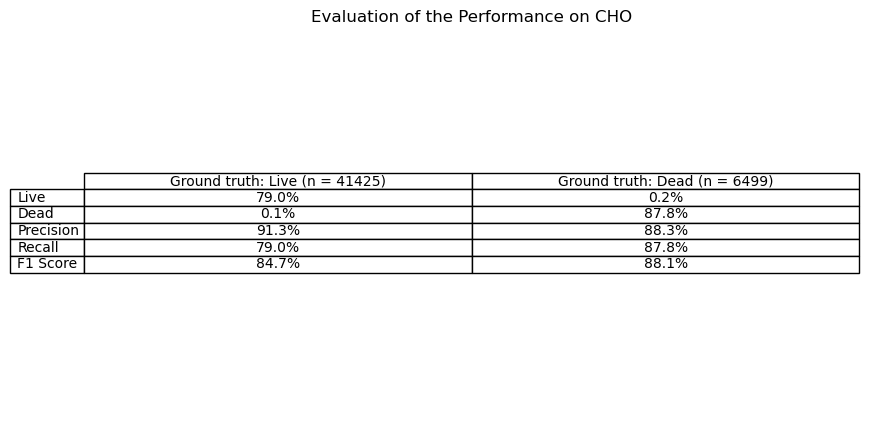

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define function to calculate pixel-wise confusion matrix metrics


# Assuming Y_val_cpu is the ground truth and preds_val_t is the predicted output
y_true = Y_val_cpu
y_pred = preds_val_t.cpu().numpy()  # Convert to numpy array if necessary

# Calculate metrics
cm, precision, recall, f1 = calculate_metrics(y_true, y_pred)

# Plot confusion matrix and metrics in table form
fig, ax = plt.subplots(figsize=(10, 5))

# Create table content
column_labels = ["Ground truth: Live (n = {})".format(np.sum(y_true == 1)), "Ground truth: Dead (n = {})".format(np.sum(y_true == 2))]
row_labels = ["Live", "Dead", "Precision", "Recall", "F1 Score"]
table_data = [
    [f"{cm[0, 0] / np.sum(y_true == 1) * 100:.1f}%", f"{cm[0, 1] / np.sum(y_true == 2) * 100:.1f}%"],
    [f"{cm[1, 0] / np.sum(y_true == 1) * 100:.1f}%", f"{cm[1, 1] / np.sum(y_true == 2) * 100:.1f}%"],
    [f"{precision[0] * 100:.1f}%", f"{precision[1] * 100:.1f}%"],
    [f"{recall[0] * 100:.1f}%", f"{recall[1] * 100:.1f}%"],
    [f"{f1[0] * 100:.1f}%", f"{f1[1] * 100:.1f}%"]
]

# Create table
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Evaluation of the Performance on CHO")
plt.show()
